In [20]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,5)

import numpy as np

24576/17858 [=========================================] - 0s 3us/step


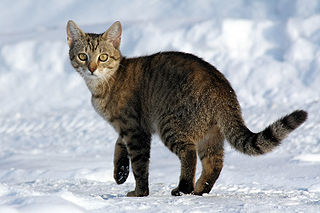

In [4]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [5]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string,channels = 3)

In [8]:
def visualize(original,augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('original image')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Augmented Image')
    plt.imshow(augmented)

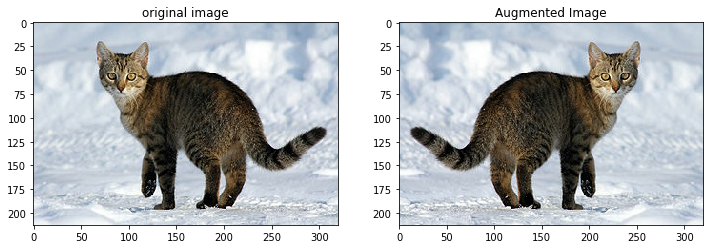

In [9]:
flipped = tf.image.flip_left_right(image)
visualize(image,flipped)

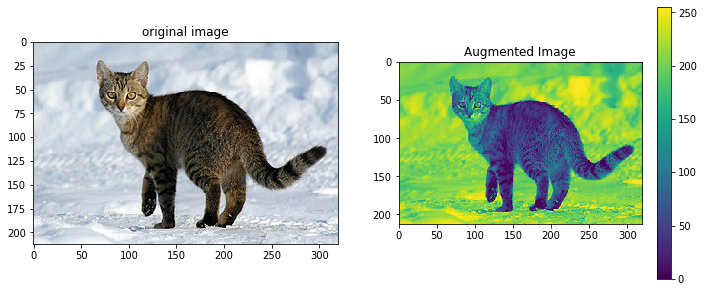

In [12]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image,tf.squeeze(grayscaled))
plt.colorbar()

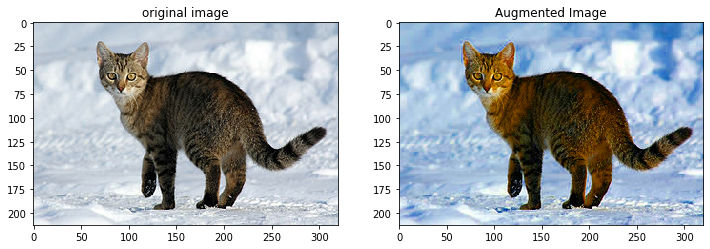

In [14]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

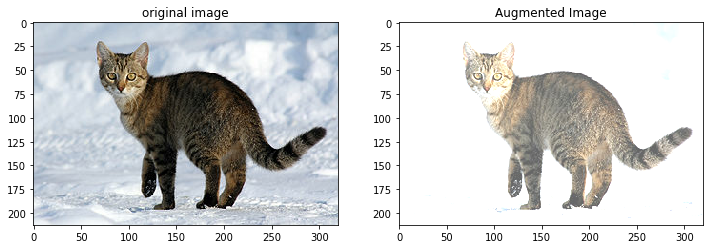

In [15]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

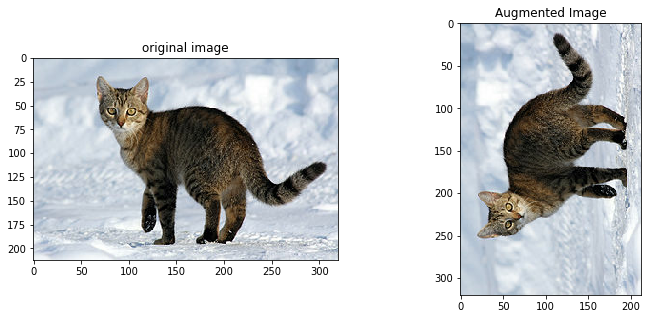

In [16]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

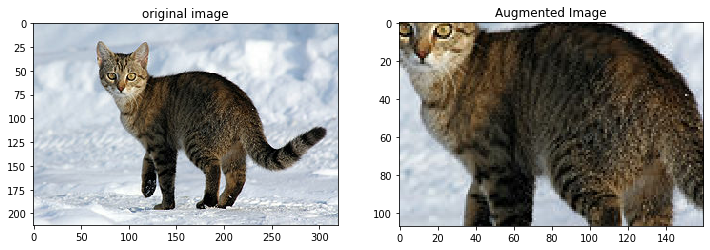

In [17]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [21]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

Shuffling and writing examples to C:\Users\preetham\tensorflow_datasets\mnist\3.0.1.incomplete8LFXOO\mnist-train.tfrecord


Shuffling and writing examples to C:\Users\preetham\tensorflow_datasets\mnist\3.0.1.incomplete8LFXOO\mnist-test.tfrecord


Dataset mnist downloaded and prepared to C:\Users\preetham\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [22]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [23]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [25]:
augmented_train_batches = (
train_dataset.take(NUM_EXAMPLES).cache()
.shuffle(num_train_examples//4)
#augmentation
.map(augment,num_parallel_calls=AUTOTUNE)
.batch(BATCH_SIZE)
.prefetch(AUTOTUNE)
)

In [26]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [27]:
validation_batches = (
test_dataset
.map(convert,num_parallel_calls = AUTOTUNE)
.batch(2*BATCH_SIZE)
)

In [34]:
def make_model():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape = (28,28,1)),
        layers.Dense(4096, activation = 'relu'),
        layers.Dense(4096,activation = 'relu'),
        layers.Dense(10)
    ])
    
    model.compile(optimizer = 'adam',
                 loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = ['accuracy'])
    return model

In [35]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches,
                                      epochs = 50,
                                       validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 14s 449ms/step - loss: 0.8206 - accuracy: 0.7505 - val_loss: 0.3857 - val_accuracy: 0.8826
Epoch 2/50
32/32 [==============================] - 11s 336ms/step - loss: 0.1812 - accuracy: 0.9419 - val_loss: 0.2867 - val_accuracy: 0.9162
Epoch 3/50
32/32 [==============================] - 11s 352ms/step - loss: 0.0684 - accuracy: 0.9756 - val_loss: 0.3017 - val_accuracy: 0.9226
Epoch 4/50
32/32 [==============================] - 11s 334ms/step - loss: 0.0462 - accuracy: 0.9839 - val_loss: 0.2710 - val_accuracy: 0.9287
Epoch 5/50
32/32 [==============================] - 12s 376ms/step - loss: 0.0246 - accuracy: 0.9932 - val_loss: 0.4045 - val_accuracy: 0.9148
Epoch 6/50
32/32 [==============================] - 14s 426ms/step - loss: 0.0325 - accuracy: 0.9883 - val_loss: 0.3841 - val_accuracy: 0.9144
Epoch 7/50
32/32 [==============================] - 11s 341ms/step - loss: 0.0718 - accuracy: 0.9731 - val_loss: 0.4682 - val_accuracy: 0.8981

In [36]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 10s 324ms/step - loss: 2.4975 - accuracy: 0.2935 - val_loss: 1.1980 - val_accuracy: 0.7003
Epoch 2/50
32/32 [==============================] - 10s 324ms/step - loss: 1.4206 - accuracy: 0.5161 - val_loss: 0.7654 - val_accuracy: 0.7528
Epoch 3/50
32/32 [==============================] - 10s 325ms/step - loss: 0.9726 - accuracy: 0.6855 - val_loss: 0.5720 - val_accuracy: 0.8315
Epoch 4/50
32/32 [==============================] - 11s 331ms/step - loss: 0.8365 - accuracy: 0.7217 - val_loss: 0.4319 - val_accuracy: 0.8748
Epoch 5/50
32/32 [==============================] - 10s 326ms/step - loss: 0.6528 - accuracy: 0.7842 - val_loss: 0.3334 - val_accuracy: 0.9009
Epoch 6/50
32/32 [==============================] - 10s 324ms/step - loss: 0.6496 - accuracy: 0.7930 - val_loss: 0.3223 - val_accuracy: 0.9047
Epoch 7/50
32/32 [==============================] - 10s 326ms/step - loss: 0.5682 - accuracy: 0.8052 - val_loss: 0.2954 - val_accuracy: 0.9060

(0.75, 1)

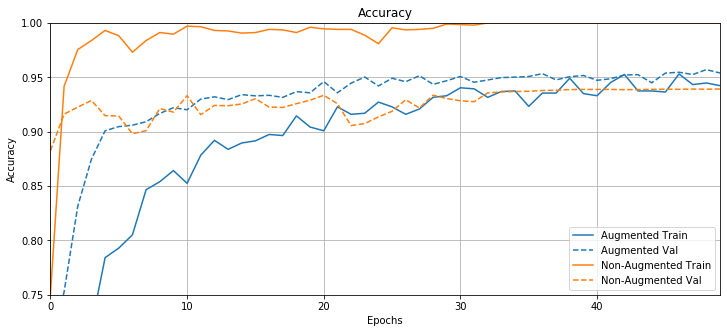

In [37]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

(0, 1)

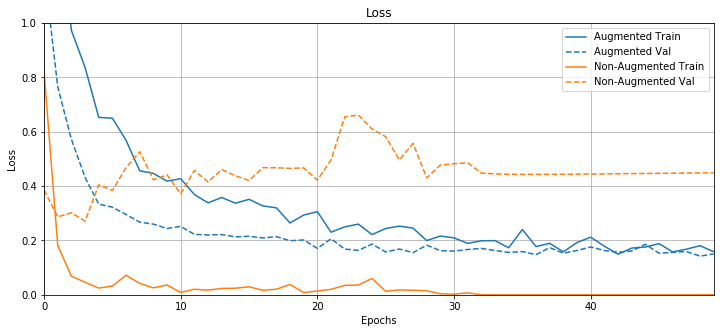

In [38]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])